In [1]:
import numpy as np
import pandas as pd
import json

import seaborn as sns
import matplotlib.pyplot as plt



#from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import recall_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score


from sklearn.pipeline import Pipeline


from tqdm import tqdm
import time




from datetime import datetime


import ast
from ast import literal_eval

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats
import ast
from ast import literal_eval


#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models


#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle



from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV


from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier

# General information Remark

### In the loading part we will recover data from 2015 to 2020, however, first visulation (part III) will only be on the data from 2020.

# I- Load the data

### Load Quotebank data

First, let's recover the quotations of interest : as our project is based on the caracterisation of speakers, we decide to pre-select the quotations that are related to a speaker (i.e speaker value is different from 'None'). 
Moreover, we select the quotations whose subject is related to climate change : to do so we will recover a list of keyword related to climate subject by analyzing wwith NLP the dataset train_climate.tcsv. Then, we select quotes that contains at least one of these words(cf chunk_filtering method).

> #### A/ Recovering of the keyword list 

In [2]:
data1 = pd.read_csv('data/Wiki_train.tsv', sep='\t')
data2=pd.read_csv('data/train_1.tsv', sep='\t')

In [3]:
data1.drop(labels = ['id', 'paragraph', 'title'], axis=1, inplace=True)
data2.drop(labels = ['id', 'paragraph', 'title'], axis=1, inplace=True)

In [4]:
subdata = pd.concat([data1, data2])

> ##### Creation of our bag of word 

In [5]:
#Convert the collection of text documents to a matrix of token counts.
#remove stop_word, and select n_gram of maximum size (1,2), lowercase = False bcause we ay recover some name's organisation. 
vectorizer = CountVectorizer(stop_words = 'english',ngram_range=(1, 2),lowercase=False)


#create bag of words features
X = vectorizer.fit_transform(subdata.sentence)


print('Number of samples:',X.toarray().shape[0])
print('Number of features:',X.toarray().shape[1])

#mask and convert to int climate
Y = np.array(subdata.label)

print(Y.shape)
print(X.shape)

#shuffle the data

X, Y = shuffle(X, Y, random_state=0)

#split into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Number of samples: 6000
Number of features: 75261
(6000,)
(6000, 75261)


TF-IDF is a popular approach used to weigh terms for NLP tasks because it assigns a value to a term according to its importance in a document scaled by its importance across all documents in your corpus. Let's transform our bag-of-word with tf-idf and see if we get better result with it.

In [6]:
tfidf_transformer = TfidfTransformer()

#transform the count matrix X_train and X_test to a normalized tf-idf representation
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_test_tfidf=tfidf_transformer.fit_transform(X_test)


X_train_tfidf.shape 
X_test_tfidf.shape

(1200, 75261)

In [7]:
train = [X_train, X_train_tfidf]
test = [X_test, X_test_tfidf]

> Train a supervised classifier based on the labeled docs

We will train logistic regression for the classification task and find the keyword related to climate. As we see previoulsy we get more feature than documents, so we need to regularized our method : we will try l2 regularization for basic logistic regression. 
We will use cross validation to hypertun our parameter and as logistic regression by default uses Gradient Descent, we will compare it to SGD Classifier which use which gradient descent making it faster. 

In [8]:
C = [0.01, 0.1, 1, 10, 100, 1000, 10000] 


param_grid = dict(C=C) 

logistic = LogisticRegression(solver = 'lbfgs', penalty = 'l2') 

grid = GridSearchCV(estimator=logistic, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 10) 

for features in (train) : 
    grid_result = grid.fit(features, Y_train) 
    print('Best Score: ', grid_result.best_score_) 
    print('Best Params: ', grid_result.best_params_) 

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Best Score:  0.9394273127753303
Best Params:  {'C': 0.1}
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Best Score:  0.9443832599118943
Best Params:  {'C': 10}


> C = 10, and tf-idf train data gives us the best score.

In [9]:
penalty = ['l1', 'l2', 'elasticnet'] 
alpha = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 10]
loss=['log', 'hinge']
max_iter=[1000, 10000, 100000, 1e6]
n_jobs = [-1]


param_grid = dict(penalty=penalty, 
alpha=alpha,loss=loss,max_iter=max_iter, n_jobs=n_jobs) 

logistic = SGDClassifier() 

grid = GridSearchCV(estimator=logistic, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 10) 

for features in (train) : 
    grid_result = grid.fit(features, Y_train) 
    print('Best Score: ', grid_result.best_score_) 
    print('Best Params: ', grid_result.best_params_) 

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best Score:  0.9302736360555744
Best Params:  {'alpha': 0.001, 'loss': 'hinge', 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l2'}
Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best Score:  0.9419518807184005
Best Params:  {'alpha': 0.0001, 'loss': 'log', 'max_iter': 100000, 'n_jobs': -1, 'penalty': 'l2'}


> SDG with logistic regression (loss = 'log'), and tf-idf train data give us approximatly the same score as for basic logitic regression. Let's use both and see which keyword we prefere. 

In [10]:
clf = LogisticRegression(random_state=0, solver='lbfgs',C = 10, penalty='l2').fit(X_train_tfidf, Y_train)
predicted = clf.predict(X_test_tfidf)
print('Accuracy:{}'.format(np.mean(predicted == Y_test)))

Accuracy:0.9508333333333333


In [11]:
coefs=clf.coef_[0] #recover coeffiction from the training
top_three = np.argpartition(coefs, -30)[-30:] # rearrange coefficient, and select the 30th first one
print(np.array(vectorizer.get_feature_names_out())[top_three])

['gases' 'fuels' 'diesel' 'greenhouse gases' 'levels' 'increase' 'gas'
 'warmer' 'carbon tax' '2010' 'climate change' 'precipitation' 'emission'
 'change' 'glaciers' 'policy' 'GHG' 'global warming' 'global' 'greenhouse'
 'cap' 'temperatures' 'Glacier' 'warming' 'increased' 'fuel' 'carbon'
 'climate' 'Climate' 'emissions']


In [12]:
clf_sdg = SGDClassifier(loss="log", penalty="l2", alpha = 0.0001,   max_iter=1e6, n_jobs=-1).fit(X_train_tfidf, Y_train)
predicted = clf_sdg.predict(X_test_tfidf)
print('Accuracy:{}'.format(np.mean(predicted == Y_test)))

Accuracy:0.95


In [13]:
coefs_sdg=clf_sdg.coef_[0]
top_three_sdg = np.argpartition(coefs_sdg, -30)[-30:]

print(np.array(vectorizer.get_feature_names_out())[top_three_sdg])

['increase' 'CO' '2010' 'precipitation' 'global warming' 'global'
 'glaciers' 'diesel' 'change' 'warming' 'warmer' 'levels' 'carbon'
 'Climate' 'climate' 'gases' 'policy' 'fuels' 'greenhouse gases' 'gas'
 'GHG' 'emissions' 'greenhouse' 'emission' 'temperatures' 'temperature'
 'Glacier' 'increased' 'cap' 'fuel']


> Both list seems resonable, let's use the one from basic logistic regression.

In [14]:
keywords = np.array(vectorizer.get_feature_names_out())[top_three]
keywords=np.delete(keywords, [4, 5, 9,13,  15, 18, 21, 24]) #remove unwanted words that can induce confusion

In [15]:
#let's see our final list
keywords

array(['gases', 'fuels', 'diesel', 'greenhouse gases', 'gas', 'warmer',
       'carbon tax', 'climate change', 'precipitation', 'emission',
       'glaciers', 'GHG', 'global warming', 'greenhouse', 'cap',
       'Glacier', 'warming', 'fuel', 'carbon', 'climate', 'Climate',
       'emissions'], dtype=object)

> #### B/ Recover climate quotation from Quotebank

In [38]:
def chunk_filtering(chunk, lst):
    template=[] #Creation of an empty list :it's always cheaper to append to a list and create a DataFrame than append on a empty dataframe.
    for i in lst: 
        template.append(chunk.loc[(chunk["quotation"].apply(lambda x : i in str(x).split(' ')) )& 
                                  (chunk["speaker"].apply(lambda x: x!= "None"))&
                                  (chunk["qids"].apply(lambda x: len(np.array(x))==1))].drop(['phase', 'urls', 'probas'], axis=1))
        #Select quotations with value in speaker column different from 'None' and 
        #quotations containing the key word and drop phase, urls and probas  column. 
        #As the speaker is identified by their name and not their QID, we select the ones that have a unique QID to facilitate our analysis.
        
    return (pd.concat(template, ignore_index=True))# return a dataframe with our data of interest

In [39]:
dico={} #We create a dictonary to loop over our years. 
for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    dico[date] = pd.read_json(f'data/quotes-{date}.json.bz2', lines=True, compression='bz2', chunksize=100000)

In [40]:
keywords = ['gases', 'fuels', 'diesel', 'greenhouse gases', 'gas', 'warmer',
       'carbon tax', 'climate change', 'precipitation', 'emission',
       'glaciers', 'GHG', 'global warming', 'greenhouse', 
       'Glacier', 'warming', 'fuel', 'carbon', 'climate', 'Climate',
       'emissions']


for date, df in dico.items() : 
    for i, chunk in enumerate(df) : 
        chunk_clean=chunk_filtering(chunk, keywords) #recover interested row of the chunk
        header = i == 0 #we kept the name of the column only for the first chunk
        mode = 'w' if i == 0 else 'a' # For appending data to an existing CSV file (so for every chunk exepct the first one), 
                                        #we can use mode = a
        chunk_clean.to_csv(path_or_buf=f"data/clean_quotes-{date}.bz2",compression='bz2',header=header, mode=mode, index = False ) #Load to CSV.    
        

In [41]:
dico_clean={} 
length = 0
for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    clean = pd.read_csv(f'data/clean_quotes-{date}.bz2', compression='bz2')
    clean.drop_duplicates(subset=['quotation']) #make sure there's no duplicate
    dico_clean[date]=clean #add to the dico
    length += len(dico_clean[date]) #The length is used here to obtain the total number of quotes. 

In [42]:
print(" At result, we extracted {} quotes fromes quotebank data".format(length))

 At result, we extracted 333004 quotes fromes quotebank data


Even with key_word selection we success to extract a satisfying quantity of data from the Quotebank data. 

# Extraction Speakers

# Load additional data Relative to speakers

## Extracted labels QIDs

The provided speaker_attributes.parquet file contains attributes in terms of QIDs, thereby being uninterpretable by humans (df_qid).
To map the QIDs to meaningful labels, we used the provided wikidata_labels_descriptions_quotebank.csv.bz2 containing the label and value for the respective QID containing the df_qid (df_label_qid).
By combining the information of both we can obtained usefull information about speakers.

#### *Load parquet file*

In [3]:
#Loading our speakers attribute dataset, and the dataset necessary to interpret our QIDs.
df_qid = pd.read_parquet("speaker_attributes.parquet",engine= "pyarrow" )
df_label_qid = pd.read_csv('data/wikidata_labels_descriptions_quotebank.csv.bz2',index_col='QID')

#### *Somes visualisation and sort of the parquet file*

In [4]:
df_qid.id.is_unique

True

In [5]:
df_qid.head(3)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None


Let's verify that academic_degree has revelant values.

In [6]:
print("There's no academic degree revelant value ? {}".format(all(df_qid.academic_degree.isna())))

There's no academic degree revelant value ? False


It seems that academic degree values are revelant, we decided to drop lastrevid, US_congress_bio_ID, type, Alisiase as they will not be used in our project.

In [7]:
df_qid.drop(['lastrevid', 'US_congress_bio_ID', 'type', 'aliases'], axis=1, inplace=True)

#### *Transformation of the df_qid with the label value from df_label_qid*

In [8]:
#We found that one of the QID was deleted from Wikidata. We will start by dropping this value, so that it does not distrurb our labelling. 

def transform(y):
    if y is None: return None
    x = set(y)
    x.discard("Q99753484")
    return np.array(list(x))
    
df_qid['occupation']=df_qid['occupation'].apply(lambda y : transform(y))

In [9]:
#We found out that some of the QIDs used in the speaker attribute file are actually redirection from an original QID. 
#We will manulally add their corresponding information using the orginal QID. We found the corespondance manualy between the two. 
#Here, there are in order, respectively the redirection QID, and its corresponding original one. One of he QID was only present 
#as a redirection, so we manually added this one (Q3186984), and its corresponding info. 

redirect_QID=['Q3268166', 'Q11815360', 'Q12014399', 'Q16287483',
              'Q20432251', 'Q21550646', 'Q13365117', 'Q13424794',
             'Q1248362', 'Q6859927', 'Q15145782',
             'Q15991263', 'Q12455619', 'Q5568256', 
             'Q6363085', 'Q11819457', 'Q12334852', 'Q15145783']
actual_QID=['Q1113899', 'Q1919436', 'Q250867', 'Q6051619',
             'Q26934816', 'Q18431816', 'Q12840545', 'Q5157338',
            'Q3455803', 'Q715222', 'Q1052281',
            'Q2743689', 'Q7019111', 'Q3738699', 
            'Q380075', 'Q3391743', 'Q476246', 'Q2449503']


lst=[['Journalist', 'monthly magazine of the United Kingdom‘s National Union of Journalists (NUJ)']]
indexes=['Q3186984']
col=['Label', 'Description']
for i in range(len(redirect_QID)):
    lst.append([df_label_qid.loc[actual_QID[i]]['Label'], 
                df_label_qid.loc[actual_QID[i]]['Description']])
    indexes.append(redirect_QID[i])

additional_df= pd.DataFrame(lst, columns= col, index=indexes)
df_label=df_label_qid.append(additional_df, ignore_index= False)

In [10]:
#Applying the function to every column containing QIDs. 
cols=['nationality', 'gender', 'ethnic_group','occupation', 'party', 'academic_degree', 'candidacy', 'religion'] #List of columns 
#containing QID to be replace

df_qid[cols] = df_qid[cols].applymap(lambda d: d if d is not None else []) #Replacing every None value with an empty list for futur analysis.
df_qid[cols] = df_qid[cols].applymap(lambda y: [df_label.loc[Q].Label for Q in y]) #Replacing QIDs with their corresponding label.

### Let's have additional data 

Now, we want to see which speakers said quotes that we consider as climate-related and climate change sceptical. We will match speaker from the df_qid with a value septic/climate. We will add two boolean columns to our dataframe df_qid: one for climate-related, and one for climate change sceptical. In order to do that, we will select every QID that appears in our list of climate-related-quotes and climat-change-sceptical quotes

In [11]:
dico_clean={} 
length = 0
for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    dico_clean[date] = pd.read_csv(f'data/clean_quotes-{date}.bz2', compression='bz2')
    length += len(dico_clean[date]) #The length is used here to obtain the total number of quotes. 

#### *Qid_climate list*

In [12]:
qid_climate=[]

#iteration in the dico_clean containing extracted files for climate involved quotes
for key, file in dico_clean.items() :
    qid_climate.append(file.drop_duplicates(['qids'], keep='first')['qids'].map(lambda y : ast.literal_eval(y)[0]).tolist()) #add unique QIDs from each file
qid_climate=set(item for sublist in qid_climate for item in sublist)#create a set with unique QIDs from each year/file.

In [13]:
print("We extracted {} QIDs related to speakers that talk about climate.".format(len(qid_climate)))

We extracted 63645 QIDs related to speakers that talk about climate.


#### *Add an additional column to df_qid*

In [14]:
df_qid['climate']=0 #create a column named climate with value equals 0
df_qid.loc[df_qid[pd.Index(df_qid.id.isin(pd.Index(qid_climate)))].index, 'climate']=1 #replace with 1 for speakers that appear in the climate-involved quotes.

In [15]:
df_qid.sample(10)

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,id,label,candidacy,religion,climate
7758145,None,[],[male],[],[property master],[],[],Q95822591,Andy Wirth,[],[],0
3044573,None,[],[male],[],[researcher],[],[],Q80621224,Pedro Nogueroles,[],[],0
7934643,[+1981-10-03T00:00:00Z],[Sweden],[male],[],[association football player],[],[],Q205773,Andreas Isaksson,[],[],0
8523930,[+1937-00-00T00:00:00Z],[],[male],[],[musical instrument maker],[],[],Q60194767,Tullio Bassi,[],[],0
8391253,None,[Song dynasty],[male],[],[],[],[],Q45367758,Bian Shen,[],[],0
8672380,None,[],[male],[],[],[],[],Q76097038,Christopher Newton,[],[],0
8275330,[+1913-06-22T00:00:00Z],[Spain],[male],[],"[anarchist, teacher]",[],[],Q19999642,Evaristo Viñuales Larroy,[],[],0
482789,None,[Ming dynasty],[male],[],[],[],[],Q45532388,Zheng Hong,[],[],0
6603722,[+1837-00-00T00:00:00Z],[],[male],[],[],[],[],Q95252981,Julius Bunzel,[],[],0
1655264,[+1962-01-01T00:00:00Z],[People's Republic of China],[],[],[politician],[Communist Party of China],[],Q51106452,None,[],[],0


## *Filter the data*

As a good data scientist, the first thing to do is to clean up the data. In order to do that, we will first check for missing rows. Then we will replace the date of birth by the year of birth. Lastly, we will filter our speakers in order to keep only the ones whose age is bewteen 12 and 100 . (As climate change is a relatively new topic, and we do not consider quotes from speakers that are younger then 12 years old).

In [16]:
print("Is there some missing rows ? {} ".format(np.array([df_qid.drop(columns=['label', 'id']).isnull().any(axis=1)]).all()))

Is there some missing rows ? False 


In [17]:
df_qid.date_of_birth=df_qid.fillna(0).date_of_birth.map(lambda y : str(y).split("-")[0][3:])#Keep only the year of birth.
df_qid=df_qid.loc[df_qid['date_of_birth'].apply(lambda x: x!= '' and int(x)>1920 and int(x)< 2008)]#Keep only speakers born after 1920.
df_qid['date_of_birth']=df_qid['date_of_birth'].astype(int)

In [18]:
df_qid.sample(5)

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,id,label,candidacy,religion,climate
6948746,1937,[United Kingdom],[male],[],"[politician, aristocrat]",[Conservative Party],[],Q5719953,"Henry Crichton, 6th Earl Erne",[],[],0
3197878,1986,[],[male],[],"[exhibition curator, historian, contributing e...",[],[],Q95087048,Adam Štěch,[],[],0
999376,1965,[Kingdom of the Netherlands],[male],[],[],[],[],Q97521309,Tom Phijffer,[],[],0
8048152,1976,[Ukraine],[male],[],"[presenter, actor]",[],[],Q4522302,Grigory Shevchuk,[],[],0
141842,1979,[United States of America],[male],[],[American football player],[],[],Q5261885,Derek Combs,[],[],0


#### *Load resulting data into a csv compressed filled*

In [19]:
df_qid.to_csv("data/speaker_attribute.bz2", compression = 'bz2', index=False)

In [2]:
speakers = pd.read_csv("data/speaker_attribute.bz2", compression = 'bz2')

In [3]:
speakers.head()

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,id,label,candidacy,religion,climate
0,1952,['United Kingdom'],['male'],['White British'],"['novelist', 'science fiction writer', ""childr...",[],[],Q42,Douglas Adams,[],[],0
1,1946,['United States of America'],['male'],[],"['statesperson', 'military officer', 'politici...",['Republican Party'],[],Q207,George W. Bush,"['2000 United States presidential election', '...","['United Methodist Church', 'Episcopal Church'...",1
2,1945,"['Canada', 'United States of America']",['male'],[],"['singer-songwriter', 'singer', 'pianist', 'fi...",[],[],Q633,Neil Young,[],[],0
3,1969,['Germany'],['male'],[],"['photographer', 'Wikimedian']",[],[],Q640,Harald Krichel,[],[],0
4,1932,"['Soviet Union', 'Russia']",['male'],[],"['biographer', 'film actor', 'screenwriter', '...",[],[],Q853,Andrei Tarkovsky,[],['Eastern Orthodox Church'],0


In [4]:
#function that removes the nan from the list of attributes 
def handle_nan(y) :
    try :
        return literal_eval(y)

    except Exception as e:
        y = y.replace("nan", "0")
        return literal_eval(y)

In [5]:
columns_eval = ['occupation','religion','nationality','ethnic_group','party','academic_degree', 'gender'] #our columns of interest
speakers[columns_eval].applymap(handle_nan) #application of the function

,occupation,religion,nationality,ethnic_group,party,academic_degree,gender
0,"[novelist, science fiction writer, children's ...",[],[United Kingdom],[White British],[],[],[male]
1,"[statesperson, military officer, politician, b...","[United Methodist Church, Episcopal Church, Me...",[United States of America],[],[Republican Party],[],[male]
2,"[singer-songwriter, singer, pianist, film acto...",[],"[Canada, United States of America]",[],[],[],[male]
3,"[photographer, Wikimedian]",[],[Germany],[],[],[],[male]
4,"[biographer, film actor, screenwriter, film di...",[Eastern Orthodox Church],"[Soviet Union, Russia]",[],[],[],[male]
...,...,...,...,...,...,...,...
2895031,[],[],[],[],[],[],[male]
2895032,[association football player],[],[],[],[],[],[]
2895033,"[university teacher, scientist]",[],[Belarus],[],[],[Doctor in Engineering],[male]
2895034,[American football player],[],[],[],[],[],[male]


In [6]:
#functions to create categorical columns  
def one_hot(list, column):
    for o in list: #Iterating over the list of genres. 
        speakers[f'{o}'] = 0 #Creating a new onehot feature column for each genre, filling it with False.
        speakers.loc[speakers[column].apply(lambda value : o in value), f'{o}'] = 1 #For each album, putting True in the 
    #onehot column corresponding to its genre. 

/var/folders/dl/g00fh9c91cddhts4q0y5fnmc0000gq/T/ipykernel_1475/2642540982.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  speakers[f'{o}'] = 0 #Creating a new onehot feature column for each genre, filling it with False.
/var/folders/dl/g00fh9c91cddhts4q0y5fnmc0000gq/T/ipykernel_1475/2642540982.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  speakers[f'{o}'] = 0 #Creating a new onehot feature column for each genre, filling it with False.
/var/folders/dl/g00fh9c91cddhts4q0y5fnmc0000gq/T/ipykernel_1475/2642540982.py:4: P

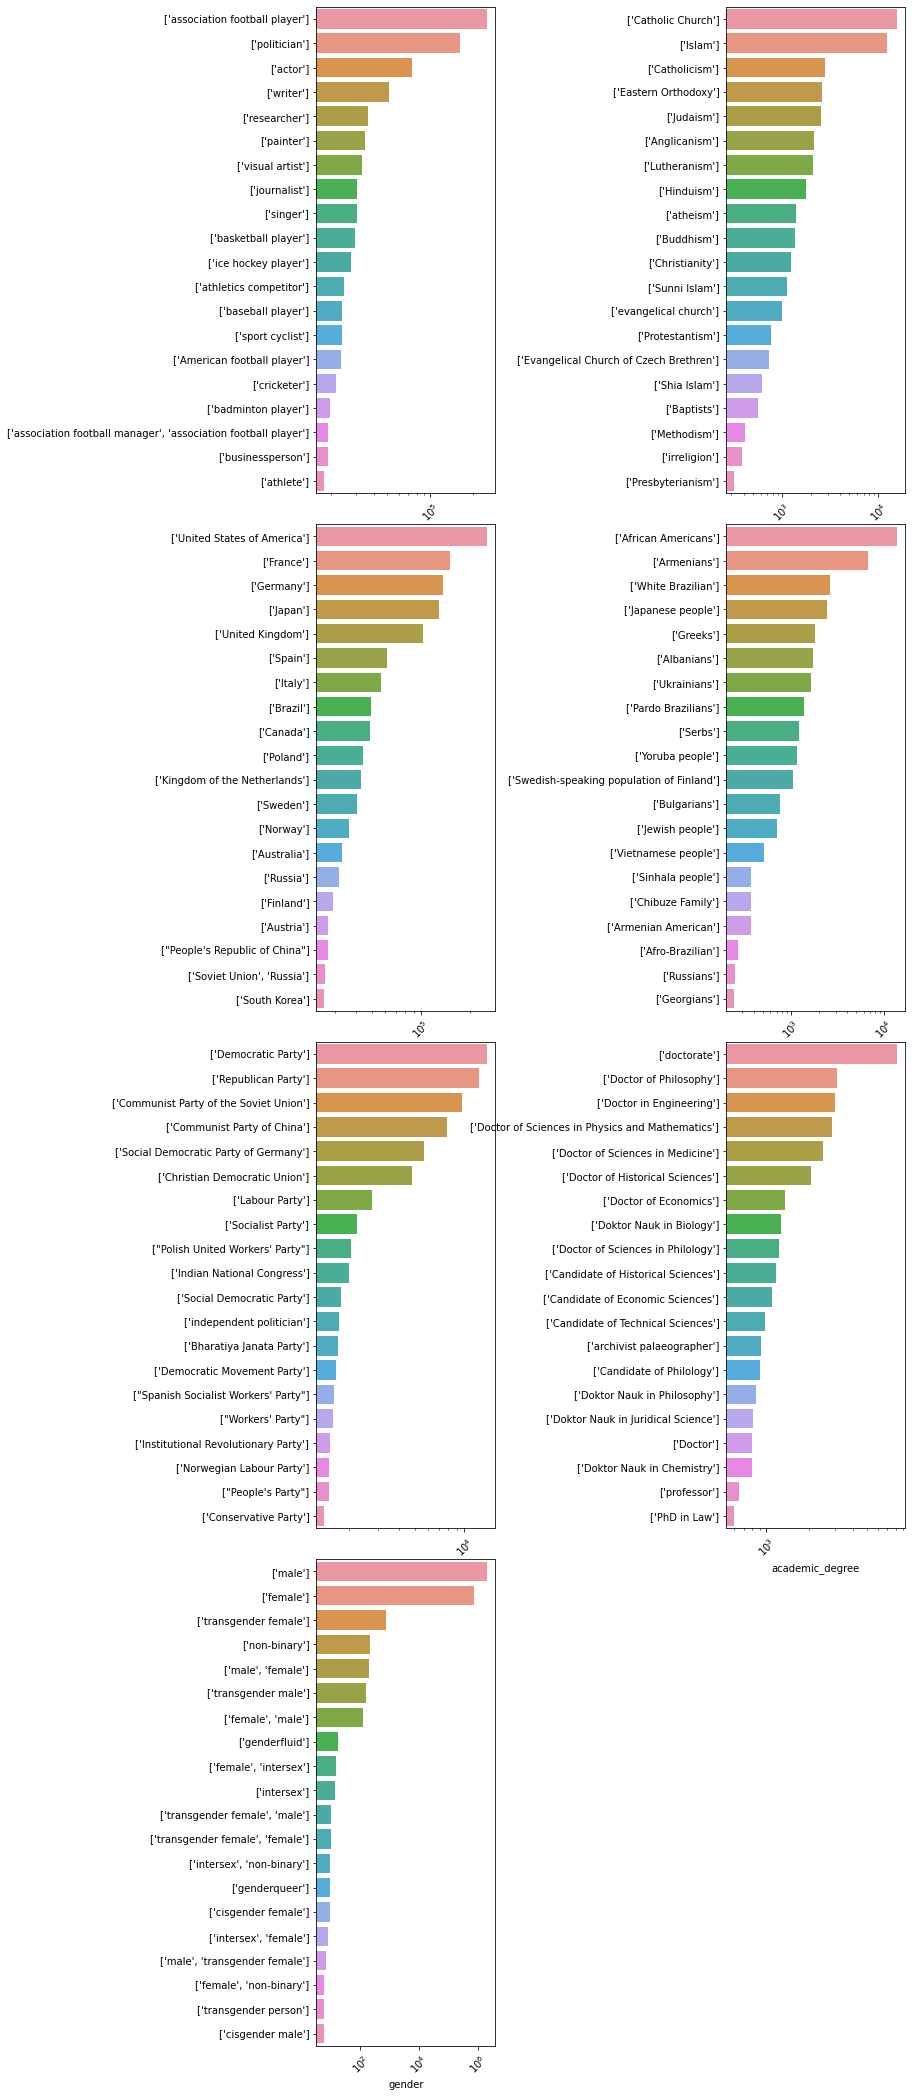

In [7]:
index = [[0,0],[0,1],[1,0],[1,1], [2,0], [2,1], [3,0]]

fig, axs = plt.subplots(4,2, figsize=(10,30))
fig.delaxes(axs[3, 1]) #The indexing is zero - based here
fig.tight_layout(pad=5, w_pad=20, h_pad=1)


for idx, column in enumerate(columns_eval): 
    
    subdata=speakers[column].explode().value_counts().drop('[]')
    sns.barplot(y= subdata.head(20).index, x = subdata.head(20), ax = axs[index[idx][0]][index[idx][1]])
    axs[index[idx][0]][index[idx][1]].tick_params(labelrotation=45, axis='x')
    axs[index[idx][0]][index[idx][1]].set(xscale='log')
    one_hot(subdata.index.tolist()[0:20], column)
    

plt.show()

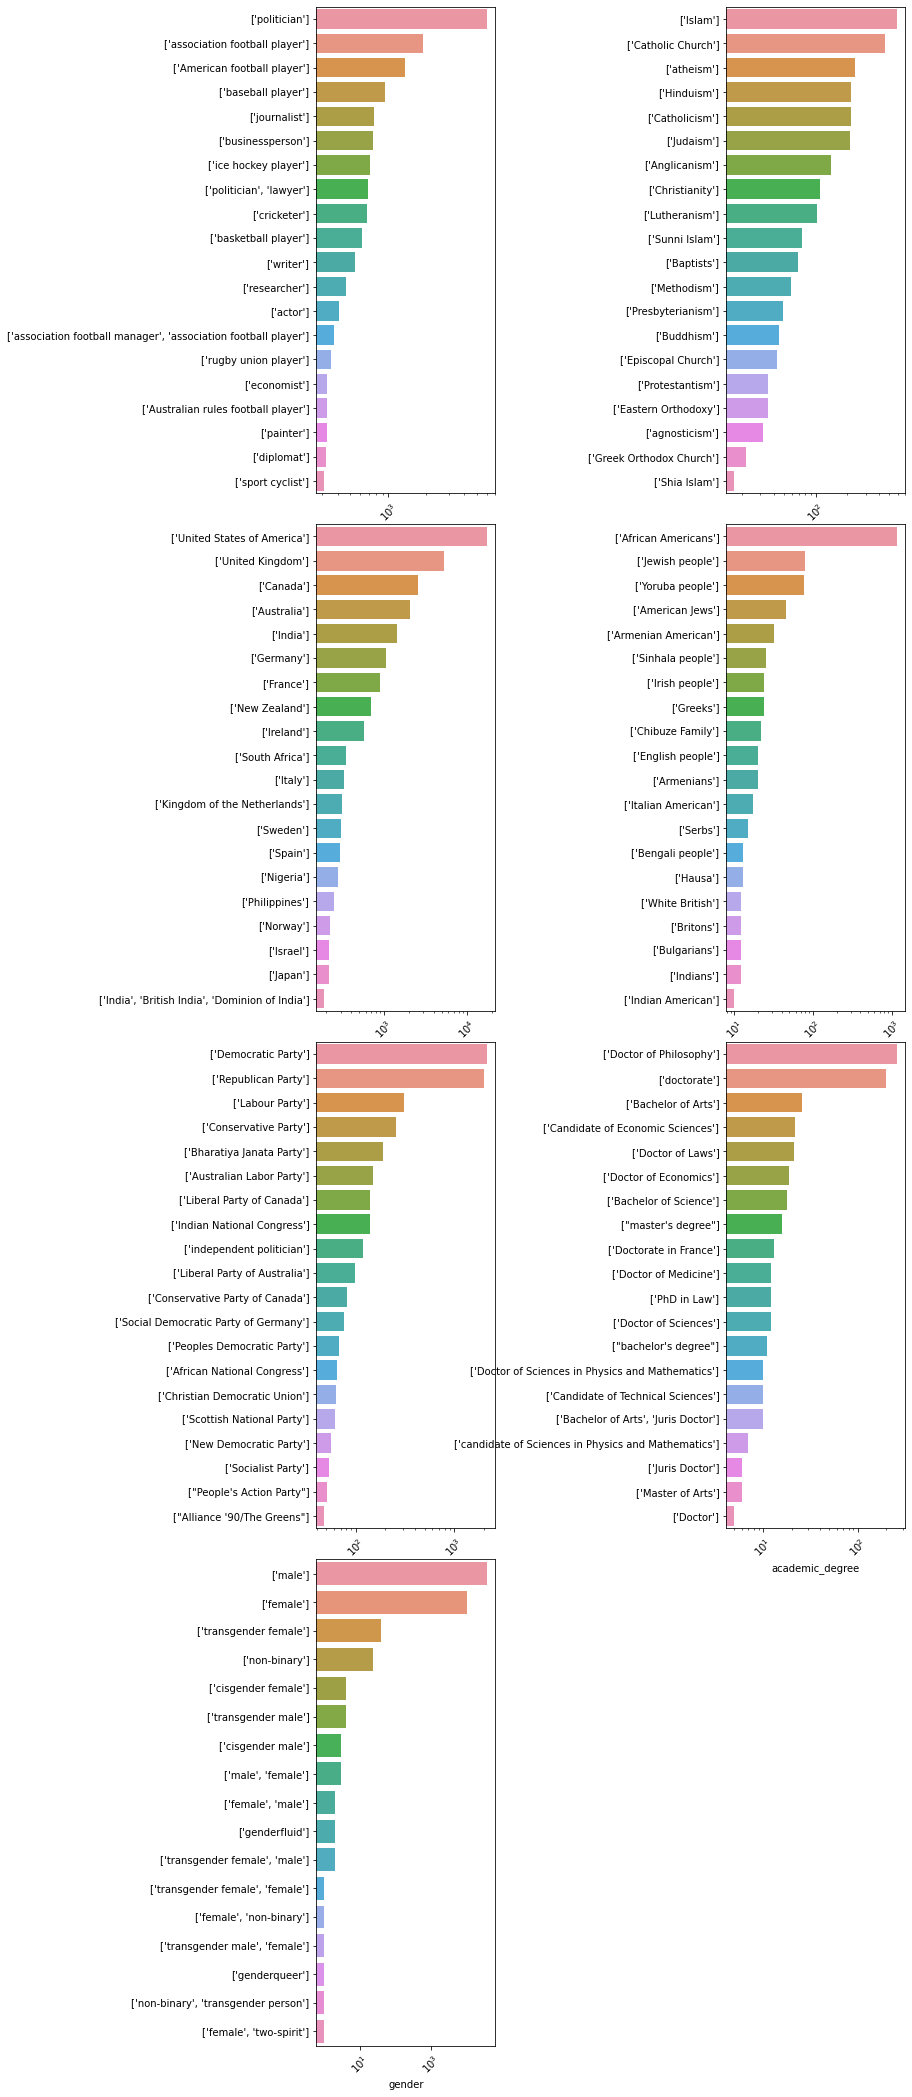

In [8]:
climate = speakers[speakers['climate']==1]
index = [[0,0],[0,1],[1,0],[1,1], [2,0], [2,1], [3,0]]

fig, axs = plt.subplots(4,2, figsize=(10,30))
fig.delaxes(axs[3, 1]) #The indexing is zero - based here
fig.tight_layout(pad=5, w_pad=20, h_pad=1)

for idx, column in enumerate(columns_eval): 
    
    subdata=climate[column].explode().value_counts().drop('[]')

    sns.barplot(y= subdata.head(20).index, x = subdata.head(20), ax = axs[index[idx][0]][index[idx][1]])
    axs[index[idx][0]][index[idx][1]].tick_params(labelrotation=45, axis='x')
    axs[index[idx][0]][index[idx][1]].set(xscale='log')



In [9]:
speakers.head(3)

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,id,label,candidacy,...,"['transgender female', 'male']","['transgender female', 'female']","['intersex', 'non-binary']",['genderqueer'],['cisgender female'],"['intersex', 'female']","['male', 'transgender female']","['female', 'non-binary']",['transgender person'],['cisgender male']
0,1952,['United Kingdom'],['male'],['White British'],"['novelist', 'science fiction writer', ""childr...",[],[],Q42,Douglas Adams,[],...,0,0,0,0,0,0,0,0,0,0
1,1946,['United States of America'],['male'],[],"['statesperson', 'military officer', 'politici...",['Republican Party'],[],Q207,George W. Bush,"['2000 United States presidential election', '...",...,0,0,0,0,0,0,0,0,0,0
2,1945,"['Canada', 'United States of America']",['male'],[],"['singer-songwriter', 'singer', 'pianist', 'fi...",[],[],Q633,Neil Young,[],...,0,0,0,0,0,0,0,0,0,0


In [10]:
speakers.drop(['occupation', 'religion', 'nationality', 
               'ethnic_group', 'party', 'academic_degree', 'id', 'candidacy', 'gender'], axis=1).to_csv('data/one_hot.bz2', compression = 'bz2', index=False)

# ORGANISATION
- classification - alicia / maria 
- temporal evolution - anissa 
- majoritiy representation - virginie
- climate speaking proprotion - virginie 
- sentiment analysis - alicia / maria 
- readme data,set  - virginie
- readme methodes - alicia / maria 
- data story (site web) - anissa

- [doing] CLASSIFICATION - Based on the evolution of the profile of a person talking about climate in the media, can we predict what characteristics will a climate-involved person have in the future ? 
 
 - [doing] TEMPORAL EVOLUTION - Is there any temporal evolution in the mediatic coverage of the climate crisis ? If so, does it correlate with specific events ? 
 
 - [doing] MAJORITY REPRESENTATION - Who are the top 10 people that talks the most about climate change over the year ? Does it show an evolution in the general opinions made publicly avaiblable by mainstream media ? What is the current typical profile of a person talking about climate in the media ? Is it the same for other topic ? (Comparaison entre les caractéristiques de personnes les plus représentées dans le QuoteBank vs celles qui parlent du climat) (comparaison des nationalités avec une carte du monde) 
 
 - [x] CLIMATE SPEAKING PROPORTION - Are some communities excluded from the mediatic discussion surround climate change ? (Comparer la proportion de chacun des communautés dans QB en général avec la propotion des communautés dans les phrases qui parlent du climat) - plot climate vs non climate 
 
 - [x] NLP TOPIC CLASSIFICATION - What is the most represented climate crisis-related topic along the years ? Does it show an evolution in the general opinions made publicly avaiblable by mainstream media ? (Trouver les mots reliés au climat les plus représentés dans les quotes chaque années) 

- [x] SENTIMENT ANALYSIS - Vander Analysis among people that talks about climate

# A RUN POUR AVOIR SUBDATA (Year-month)

In [37]:
dico_clean={} 
length = 0
for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    dico_clean[date] = pd.read_csv(f'data/clean_quotes-{date}.bz2', compression='bz2')
    length += len(dico_clean[date]) #The length is used here to obtain the total number of quotes.

In [38]:
subdata=pd.DataFrame()
for years, quotes in dico_clean.items() : 
    subdata = pd.concat([subdata, quotes])

In [39]:
subdata.date.map(lambda y : datetime.strptime(y, '%Y-%m-%d %H:%M:%S'))
subdata.sort_values(by='date', inplace=True)
subdata['date'] = pd.to_datetime(subdata['date']).dt.strftime('%Y-%m')

# Temporal Evolution - ANISSA

> Years and month 

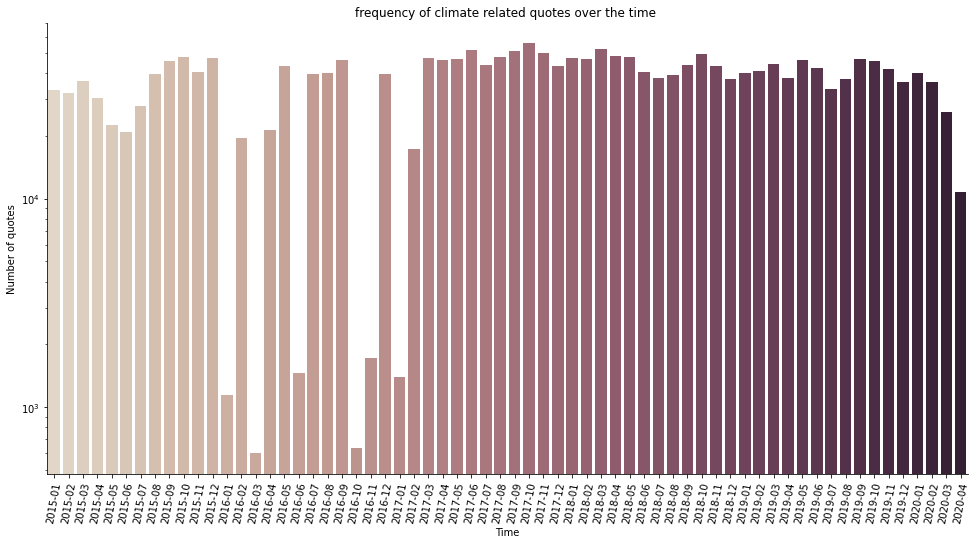

In [5]:
ax=sns.catplot(data=subdata, x = 'date',  kind="count", 
               palette="ch:.25",height=7, aspect=2)
ax.set_xticklabels(rotation=80)

ax.set(xlabel='Time', ylabel='Number of quotes', 
       title= 'frequency of climate related quotes over the time ', yscale='log') #We chose a log scale for better data visulalisation. 

sns.despine()

> Years

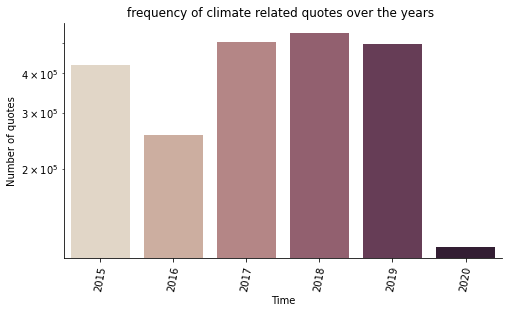

In [6]:
subdata_years = subdata.copy()
subdata_years['date'] = pd.to_datetime(subdata_years['date']).dt.strftime('%Y')


ax=sns.catplot(data=subdata_years, x = 'date',  kind="count", 
               palette="ch:.25",height=4, aspect=1.8)

ax.set_xticklabels(rotation=80)

ax.set(xlabel='Time', ylabel='Number of quotes', 
       title= 'frequency of climate related quotes over the years ', yscale='log') #We chose a log scale for better data visulalisation. 

sns.despine()

# Majority representation - VIRGINIE

In [ ]:
top_10 = subdata.copy()
speaker_time = top_10[['speaker','date','numOccurrences']]
count_top_10 = speaker_time.groupby('speaker')['numOccurrences'].agg(['count']).sort_values('count', ascending=False).head(10)

In [ ]:
count_top_10

In [ ]:
speaker_list = speaker_time['speaker'].tolist()

x = 0 
big_ls = []

for i in count_top_10.index:
    ls = []
    x = x+1
    if i in speaker_list:
        ls.append(speaker_time['date'])
        big_ls.append(ls)

count_top_10['date'] = big_ls
count_top_10

In [ ]:
x_speaker = count_top_10.index.tolist()
y_count = count_top_10['count']

count_top_10.plot.bar()

# Climate speaking proprotion - VIRGINIE

# NLP - Sentiment Analysis

In [2]:
import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle 

seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models as gensimvis
#import pyLDAvis.gensim

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

In [3]:
analyzer = SentimentIntensityAnalyzer()

In [4]:
dico={} #We create a dictonary to loop over our years. 
for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    dico[date] = pd.read_csv(f"data/clean_quotes-{date}.bz2", compression = 'bz2')

In [5]:
dico_quotes = {}
for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    dico_quotes[date] = dico[date]['quotation']

In [6]:
def print_sentiment(text):
    
    vs = analyzer.polarity_scores(text)
    print(text, '\n')
    print('Negative sentiment:',vs['neg'])
    print('Neutral sentiment:',vs['neu'])
    print('Positive sentiment:',vs['pos'])
    print('Compound sentiment:',vs['compound'])
    return vs 

## Distributions

### Positive and negative distributions through the years

In [17]:
positive_sent = {}
negative_sent = {}
ls_pos = []
ls_neg = []

#iterate through the sentencs, get polarity scores, choose a value

for date in [2020,2019, 2018, 2017, 2016, 2015]:
    for quote in dico_quotes[date]:
        ls_pos.append(analyzer.polarity_scores(quote)['pos'])
        ls_neg.append(analyzer.polarity_scores(quote)['neg'])
    
    positive_sent[date] = ls_pos
    negative_sent[date] = ls_neg

In [18]:
def get_above_zero(my_list):
    np_arr = np.array(my_list)
    return np_arr[np_arr > 0]

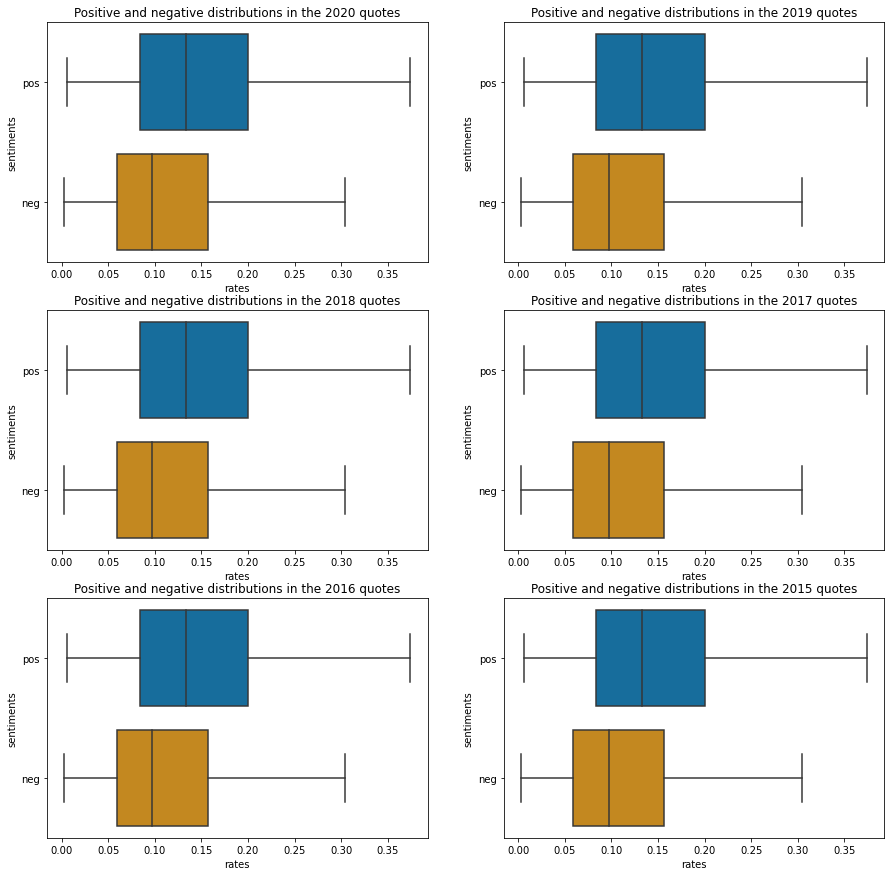

In [ ]:
fig, axes = plt.subplots(3,2, figsize=(15,15))




for i, date in enumerate(positive_sent.keys()): #add colors palette and 2015->2020
    to_plot = [get_above_zero(positive_sent[date]),get_above_zero(negative_sent[date])]
    line, col = divmod(i, 2)
    sns.boxplot(data = to_plot, orient = "h", ax = axes[line,col],showfliers=False, palette = 'colorblind').set(title = f'Positive and negative distributions in the {date} quotes', xlabel='rates', ylabel='sentiments')
    axes[line,col].set_yticklabels(['pos','neg'])

interpretation

### Neutral ditribution

In [32]:
neutral_sent = {}
ls_neu = []


#iterate through the sentencs, get polarity scores, choose a value

for date in [2020,2019, 2018, 2017, 2016, 2015]:
    for quote in dico_quotes[date]:
        ls_neu.append(analyzer.polarity_scores(quote)['neu'])
    
    neutral_sent[date] = ls_neu

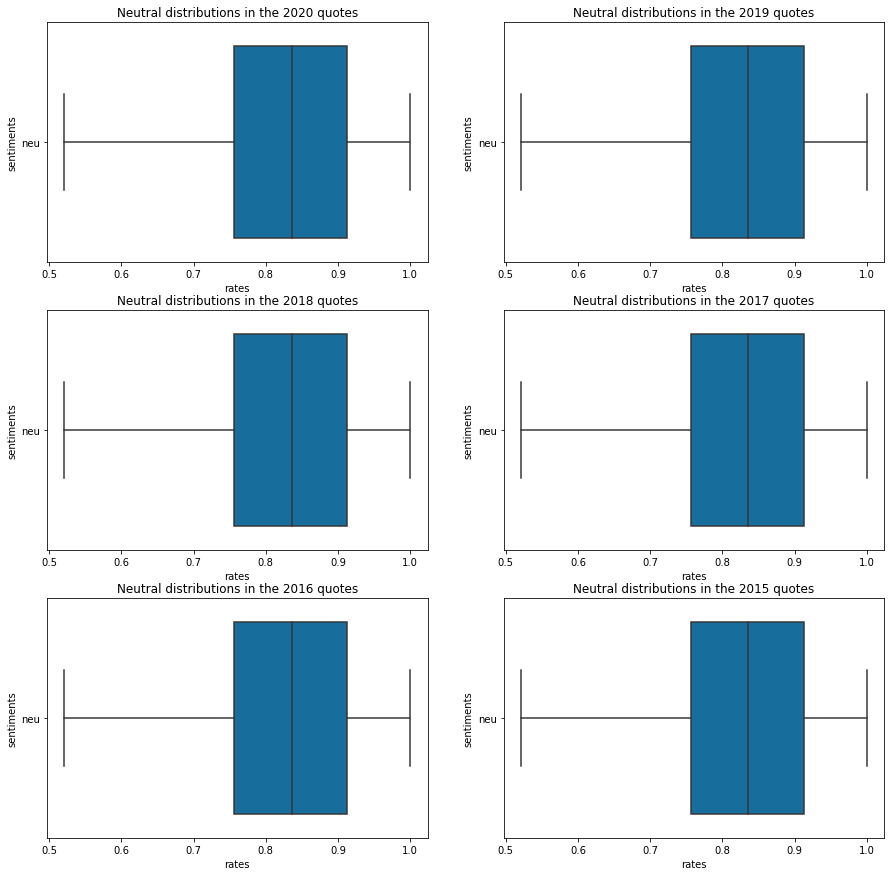

In [33]:
fig, axes = plt.subplots(3,2, figsize=(15,15))

for i, date in enumerate(neutral_sent.keys()): 
    to_plot = [get_above_zero(neutral_sent[date])]
    line, col = divmod(i, 2)
    sns.boxplot(data = to_plot, orient = "h", ax = axes[line,col],showfliers=False,palette = 'colorblind').set(title = f'Neutral distributions in the {date} quotes', xlabel='rates', ylabel='sentiments')
    axes[line,col].set_yticklabels(['neu'])

interpretation

## A comparison of the two main politic party

In [58]:
subdata

,quoteID,quotation,speaker,qids,date,numOccurrences
43960,2015-01-01-037433,We knew going into the game that Glasgow are a...,Jack Cuthbert,['Q6111953'],2015-01,1
18610,2015-01-01-014223,"I'd like to thank my teammates, coaches and ou...",Justin Houston,['Q12060573'],2015-01,1
12414,2015-01-01-036860,We have a Government now whose economic policy...,Jeanette Fitzsimons,['Q444691'],2015-01,2
42279,2015-01-01-014311,"If climate justice was lightning, then we woul...",Ban Ki-moon,['Q1253'],2015-01,1
14484,2015-01-01-041705,"You and I like the low gas prices, but you rea...",Joe Pickett,['Q16187264'],2015-01,1
...,...,...,...,...,...,...
4116,2020-04-16-008226,"Climate change, in other words, may make the d...",Marco Tedesco,['Q58222223'],2020-04,1
14313,2020-04-16-020492,"I think that my being Irish American, the gran...",Elizabeth Dennehy,['Q529120'],2020-04,1
16498,2020-04-16-035871,On Monday I went to the McDonalds drive throug...,Peter Baldacchino,['Q15840025'],2020-04,1
1248,2020-04-16-039463,Rhode Island is especially vulnerable to the e...,Peter Kilmartin,['Q7175189'],2020-04,1


In [81]:
speaker = pd.read_csv('data/one_hot.bz2', compression='bz2')

In [85]:
speaker.columns = speaker.columns.str.replace("[',']", '')

In [86]:
speaker

,date_of_birth,label,climate,[association football player],[politician],[actor],[writer],[researcher],[painter],[visual artist],...,[transgender female male],[transgender female female],[intersex non-binary],[genderqueer],[cisgender female],[intersex female],[male transgender female],[female non-binary],[transgender person],[cisgender male]
0,1952,Douglas Adams,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1946,George W. Bush,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1945,Neil Young,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1969,Harald Krichel,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1932,Andrei Tarkovsky,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895031,1960,Michael Felix Suarez,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2895032,2002,Moameen Mutasem,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2895033,1952,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2895034,1926,John Nolan,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
republicans_climate = speaker[['[Republican Party]','label']]
democratic_climate = speaker[['[Democratic Party]','label']]

In [108]:
def quotes_politics(list): 
    template=[] 
    for n in list: 
        template.append(subdata.loc[(subdata["speaker"].apply(lambda x : n in str(x).split(' ')) )])
    return pd.concat(template, ignore_index=True)# return a dataframe with our data of interest

In [112]:
def quotes_sentiments(list): 
    ls_pos = []
    ls_neg = []
    for n in list: 
        ls_pos.append(analyzer.polarity_scores(n)['pos'])
        ls_neg.append(analyzer.polarity_scores(n)['neg'])
        
    return ls_pos,ls_neg      

In [109]:
df_demo = quotes_politics(democratic_climate[democratic_climate['[Democratic Party]'] == 1]['label'])
df_repu = quotes_politics(republicans_climate[republicans_climate['[Republican Party]'] == 1]['label'])

In [114]:
ls_pos_rep, ls_neg_rep = quotes_sentiments(df_repu['quotation'])
ls_pos_dem, ls_neg_dem = quotes_sentiments(df_demo['quotation'])

[Text(0, 0, 'rep'), Text(0, 1, 'dem')]

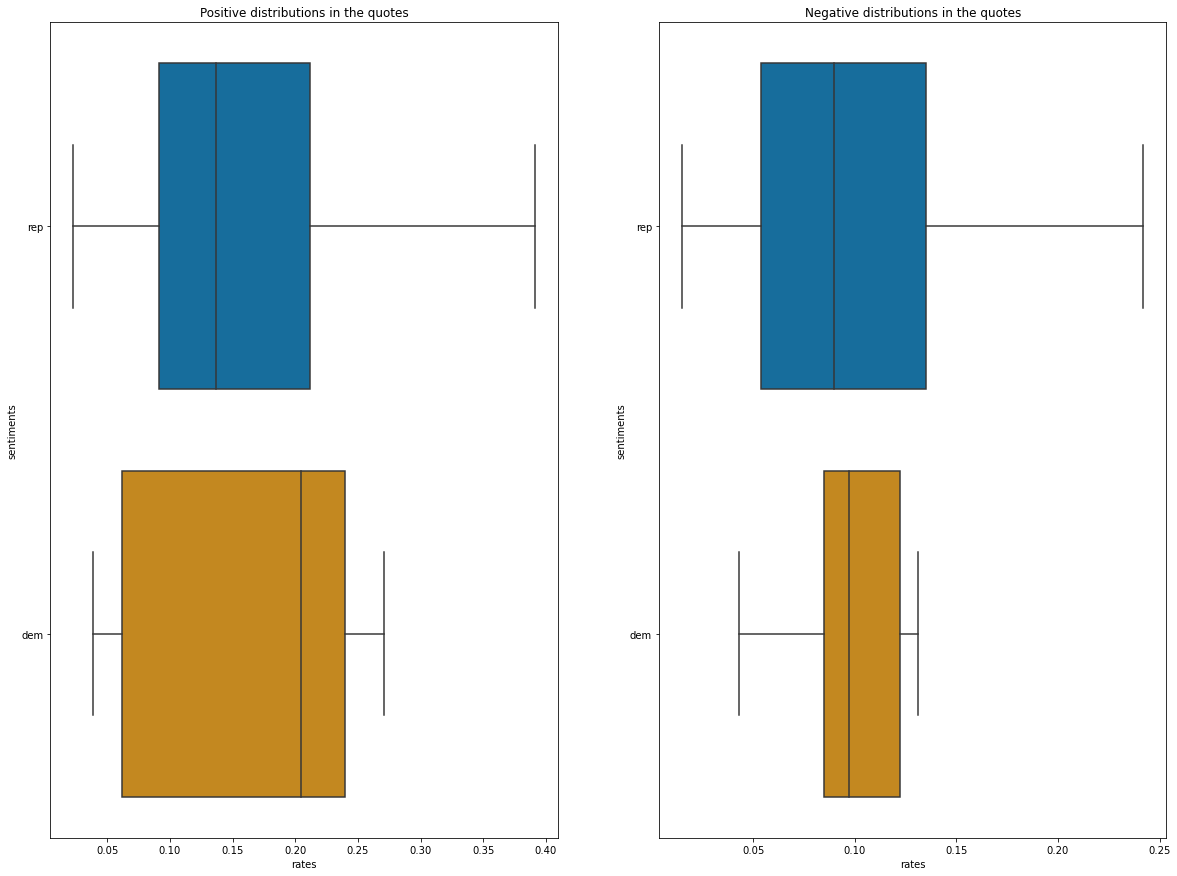

In [140]:
fig, axes = plt.subplots(1,2, figsize=(20,15))


to_plot = [get_above_zero(ls_pos_rep),get_above_zero(ls_pos_dem)]
sns.boxplot(data = to_plot, orient = "h", ax = axes[0],showfliers=False, palette = 'colorblind').set(title = 'Positive distributions in the quotes', xlabel='rates', ylabel='sentiments')
axes[0].set_yticklabels(['rep','dem'])

to_plot = [get_above_zero(ls_neg_rep),get_above_zero(ls_neg_dem)]
sns.boxplot(data = to_plot, orient = "h", ax = axes[1],showfliers=False, palette = 'colorblind').set(title = 'Negative distributions in the quotes', xlabel='rates', ylabel='sentiments')
axes[1].set_yticklabels(['rep','dem'])

# *Methods* 

In [2]:
#method to compute the confusion matrix 
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5): 
    
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int)   
                                                                                                                       
    TP = np.sum(np.logical_and(predict_label==1, true_label==1))
    TN = np.sum(np.logical_and(predict_label==0, true_label==0))
    FP = np.sum(np.logical_and(predict_label==1, true_label==0))
    FN = np.sum(np.logical_and(predict_label==0, true_label==1))
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]])
    return confusion_matrix


#method to plot the matrix 
def plot_confusion_matrix(confusion_matrix):
    
    [[TP, FP],[FN, TN]] = confusion_matrix  #define the matrix
    
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]]) #label the boxes of the confusion matrix
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative'])  
    
    return sns.heatmap(df_cm, cmap='GnBu', annot=label, annot_kws={"size": 16}, cbar=False, fmt='') #plot heatmap


#compute the score 
def compute_all_score(confusion_matrix, t=0.5):
    [[TP, FP],[FN, TN]] = confusion_matrix.astype(float)
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    
    #calculate the precision  (what fraction of positive predictions is true)
    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
    precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan
    
    #calculate the recall (what fraction of positive example are recognized as such)
    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
    recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan
    
    #harmonic mean of the recall and precision

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan

    return [t, accuracy, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative]

In [3]:
def accuracy (matrix_confusion) : 
  
 #recover the different performance of the classifier 
    [t, accuracy, precision_positive, recall_positive, F1_score_positive, \
    precision_negative, recall_negative, F1_score_negative] = compute_all_score(matrix_confusion)
    
 #print them 

    print("The accuracy of this model is {0:1.3f}".format(accuracy))
    print("For the positive case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_positive, recall_positive, F1_score_positive))
    print("For the negative case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_negative, recall_negative, F1_score_negative))
    

In [4]:
def features_imp (train_f, params) :
    
    tmp = []
    for name, value in zip(train_f, params):
        tmp.append({"name": name, "value": value}) #concatenate value and names of the features

    features_coef = pd.DataFrame(tmp).sort_values("value")
    features_coef.head() # visualise first coefficient
    
    plt.subplots(figsize=(8,25))
    ax = sns.barplot(y= features_coef.name, x=features_coef.value, palette ="light:b")   #plot features_names and their relative importance into the model
 


## *Data preparation*

We recovered data from Handling_categorical_data and separate it to train and test set to performs our classification for climate.

In [6]:
data_original = pd.read_csv("data/one_hot.bz2", compression = 'bz2') #load the data one hot encoding

In [7]:
data = data_original.drop(['label'], axis=1).copy() #drop the label column
data.head(3)

,date_of_birth,climate,['association football player'],['politician'],['actor'],['writer'],['researcher'],['painter'],['visual artist'],['journalist'],...,"['transgender female', 'male']","['transgender female', 'female']","['intersex', 'non-binary']",['genderqueer'],['cisgender female'],"['intersex', 'female']","['male', 'transgender female']","['female', 'non-binary']",['transgender person'],['cisgender male']
0,1952,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1946,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1945,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


*preparation of our features*

In [8]:
X = data.drop(['climate'],axis=1)
y = data['climate']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #split data into train and test set 

## *Fit To “Baseline” Logistic classification*

Now we create a “baseline” for logistic classifier with stochastic gradient. This model uses all of the unmodified features and the default settings defined in the Scikit-learn logistic regression documentation. Basline model are simple model that are less likely to overfit and likely to be interpretable. it can helps us to get a better view on our data and show us a direction for the feature engineering. Moreover, comparaison between baseline and engineered model will helps us to conclude about our classification. 

The accuracy of this model is 0.983
For the positive case, the precision is nan, the recall is 0.000 and the F1 score is nan
For the negative case, the precision is 0.983, the recall is 1.000 and the F1 score is 0.992


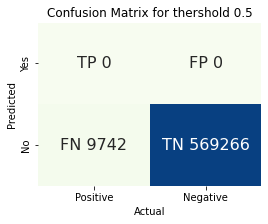

In [391]:
logistic=LogisticRegression(max_iter = 1000) #we indicate this parameters otherwise the model does not converge
logistic.fit(X_train, y_train)

prediction_proba=logistic.predict_proba(X_test) 
    
#construct the confusion matrix
confusion_matrix_05_baseline = compute_confusion_matrix(y_test, prediction_proba, 0.5)

plt.figure(figsize = (4,3))   
ax = plot_confusion_matrix(confusion_matrix_05_baseline)

#setting axis
plt.xlabel('Actual')
plt.ylabel('Predicted')
ax.set(title = 'Confusion Matrix for thershold 0.5')
    
#get the accuracy of the model
accuracy (confusion_matrix_05_baseline)

Based on the baselin model we can observe that our data is largely imbalanced : the classifier tend to alway predict 0 for climate and still get an amazing accarucy ! However, if we take a look at the F-score for positive case, we can observe that it is null... In fact, climate speakers are in minority in our data and so we need to modify our training set to get a satisfy classification. 

## *Modification of our training set*

*undersampling*

In [342]:
print('We have {} speakers talking about climate'.format(len(data_features[data_features['climate']==1])))
print('We have {} speakers that do not talking about climate'.format(len(data_features[data_features['climate']==0])))

We have 48722 speakers talking about climate
We have 2846314 speakers that do not talking about climate


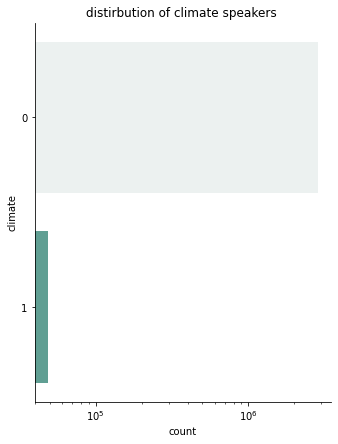

In [392]:
ax = sns.catplot(y="climate", data=data,
                kind="count", height=6, aspect=.8, palette="light:#5A9")
ax.set(xscale='log', title = 'distirbution of climate speakers ')
plt.show()

As we can see we have an  imbalanced datasets examples where climate speakers are in the minority class. This distribution cause bias in the training dataset and can influence our classification leading some to ignore the minority class entirely. We decided to manage this problem by randomly resampling the training dataset. The two main approaches are to delete examples from the majority class, called undersampling, and to duplicate examples from the minority class, called oversampling. In frame with the dimension of our dataset we decided to go with undersamplig.

In [31]:
undersample = RandomUnderSampler(sampling_strategy=0.5) #stategy = 0,5, majority class yill be the same amount as the minority class (1 to 1)

# fit and apply the transform into the train set
X_smote, y_smote = undersample.fit_resample(X_train, y_train)

In [32]:
print('Before undersampling we get {} non climate outcome, after undersampling we get {} climate outcome'.format(y_train.value_counts()[0], y_smote.value_counts()[0]))

Before undersampling we get 2277048 non climate outcome, after undersampling we get 77960 climate outcome


As we get a large number of features, dimensionality reduction could be an option, let's visualize the variance explained by each feature in order to select an interval containing the major components for the PCA 

*PCA on training set*

In [33]:
#scale our dataset : Standardize features by removing the mean and scaling to unit variance.
scaler=StandardScaler()
scaler.fit(X_smote)
train_scaled = pd.DataFrame(scaler.transform(X_smote), columns=X_smote.columns) 
test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns) 

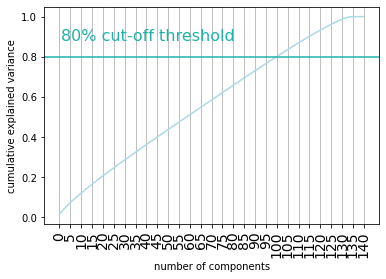

In [34]:
pca = PCA().fit(train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_), color = 'lightblue')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.axhline(y=0.8, color='lightseagreen', linestyle='-')
plt.text(0.5, 0.88, '80% cut-off threshold', color = 'lightseagreen', fontsize=16)
plt.xticks(np.arange(0, 142, step=5), rotation=90, fontsize=14)
plt.grid(axis='x')
plt.show()

In [36]:
#Creation of Dataframe containing the major components
evr = pca.explained_variance_ratio_
cvr = np.cumsum(pca.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(100))

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.015071,0.015071
1,0.027874,0.012804
2,0.040419,0.012545
3,0.051742,0.011323
4,0.062427,0.010685
...,...,...
95,0.766422,0.007061
96,0.773481,0.007059
97,0.780520,0.007039
98,0.787540,0.007020


Based on the graph we can see that each component does not have a great explained variance (<<0.02..), it seems that component beyteen 95 and 100 are required to explained at least 80% of the variance.

## *Logistic Regression*

Logistic regression measures the relationship between variable by estimating probabilities using a logistic function.
One thing we may want to do is rescale the features/inputs. Rescaling data brings values that may have extremely different ranges or units into alignment with one another. Bringing all the measurements into a similar scale helps the performance of the classifier (for a comparison try dropping the scaling and see how your performance decreases), and we can accomplish this with the StandardScaler from sklearn library. Another idea as already mention is to test for PCA.

*without  scaling and PCA*

In [37]:
#declaration of a pipe flow

pipe = Pipeline([('logistic',LogisticRegression())])
    

# pipe flow is :
#  undersample train data  -> logistic regression


#different parameters for hypertunning

penalty = ['l2'] 
solver=['lbfgs']
max_iter=[100, 1000, 10000]
C = [0.001,0.01,  0.1, 1, 10, 100] 


# make lists of different parameters to check
param_grid = dict(logistic__penalty=penalty,
logistic__C=C,logistic__solver=solver,logistic__max_iter=max_iter) 



    
# initialize
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 5) 
    
#fit
grid_result = grid.fit(X_smote, y_smote) 
    
#print score and params of the best model
print('Best Score: ', grid_result.best_score_) 
print('Best Params: ', grid_result.best_params_) 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Score:  0.7831686060210061
Best Params:  {'logistic__C': 100, 'logistic__max_iter': 1000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}


*standarized without PCA* 

In [38]:
#declaration of a pipe flow

pipe = Pipeline([('std_slc', StandardScaler()),  
                 ('logistic',LogisticRegression()), ]
                 )
    
    
# pipe flow is :
#  Scaling the data -> logistic regression


#different parameters for hypertunning

penalty = ['l2'] 
solver=['lbfgs']
max_iter=[100, 1000, 10000]
C = [0.001,0.01,  0.1, 1, 10, 100] 


# make lists of different parameters to check
param_grid = dict(logistic__penalty=penalty,
logistic__C=C,logistic__solver=solver,logistic__max_iter=max_iter) 



    
# initialize
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 5) 
    
#fit
grid_result = grid.fit(X_smote, y_smote) 
    
#print score and params of the best model
print('Best Score: ', grid_result.best_score_) 
print('Best Params: ', grid_result.best_params_) 
print('Best Params: ', grid_result.best_params_) 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Score:  0.8057693378430638
Best Params:  {'logistic__C': 0.1, 'logistic__max_iter': 100, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Best Params:  {'logistic__C': 0.1, 'logistic__max_iter': 100, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}


*With PCA*

In [40]:
#declaration of a pipe flow
pipe = Pipeline([('std_slc', StandardScaler()),
                ('pca', PCA()),
                ('logistic',LogisticRegression())])
    
    
# pipe flow is :
# PCA(Dimension reduction to two) -> Scaling the data -> logistic regression


#different parameters for hypertunning
n_components=[95, 100]
penalty = ['l2'] 
solver=['lbfgs']
max_iter=[100, 1000, 10000]
C = [0.001, 0.1, 1, 10, 100]


# make lists of different parameters to check
param_grid = dict(pca__n_components=n_components, logistic__penalty=penalty, 
logistic__C=C,logistic__solver=solver,logistic__max_iter=max_iter) 



    
# initialize
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv =5) 
    
#fit
grid_result = grid.fit(X_smote, y_smote) 
    
#print score and params of the best model
print('Best Score: ', grid_result.best_score_) 
print('Best Params: ', grid_result.best_params_) 

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Score:  0.7939929298970857
Best Params:  {'logistic__C': 0.1, 'logistic__max_iter': 100, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs', 'pca__n_components': 100}


-> we can see that the second model returns the best accuracy: let's use it for our classification. 

## *Let's see the result !*

The accuracy of this model is 0.862
For the positive case, the precision is 0.070, the recall is 0.582 and the F1 score is 0.124
For the negative case, the precision is 0.992, the recall is 0.867 and the F1 score is 0.925


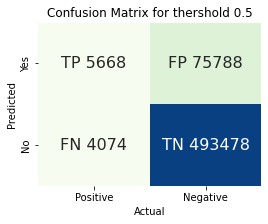

In [41]:
logistic=LogisticRegression(solver ='lbfgs', penalty = 'l2', C=0.1, max_iter=100)
logistic.fit(train_scaled, y_smote)

prediction_proba=logistic.predict_proba(test_scaled) 
    
#construct the confusion matrix
confusion_matrix_05_model = compute_confusion_matrix(y_test, prediction_proba, 0.5)

plt.figure(figsize = (4,3))   
ax = plot_confusion_matrix(confusion_matrix_05_model)

#setting axis
plt.xlabel('Actual')
plt.ylabel('Predicted')
ax.set(title = 'Confusion Matrix for thershold 0.5')
    
#get the accuracy of the model
accuracy (confusion_matrix_05_model)
    

#### 2.2 - Remove features vs not 

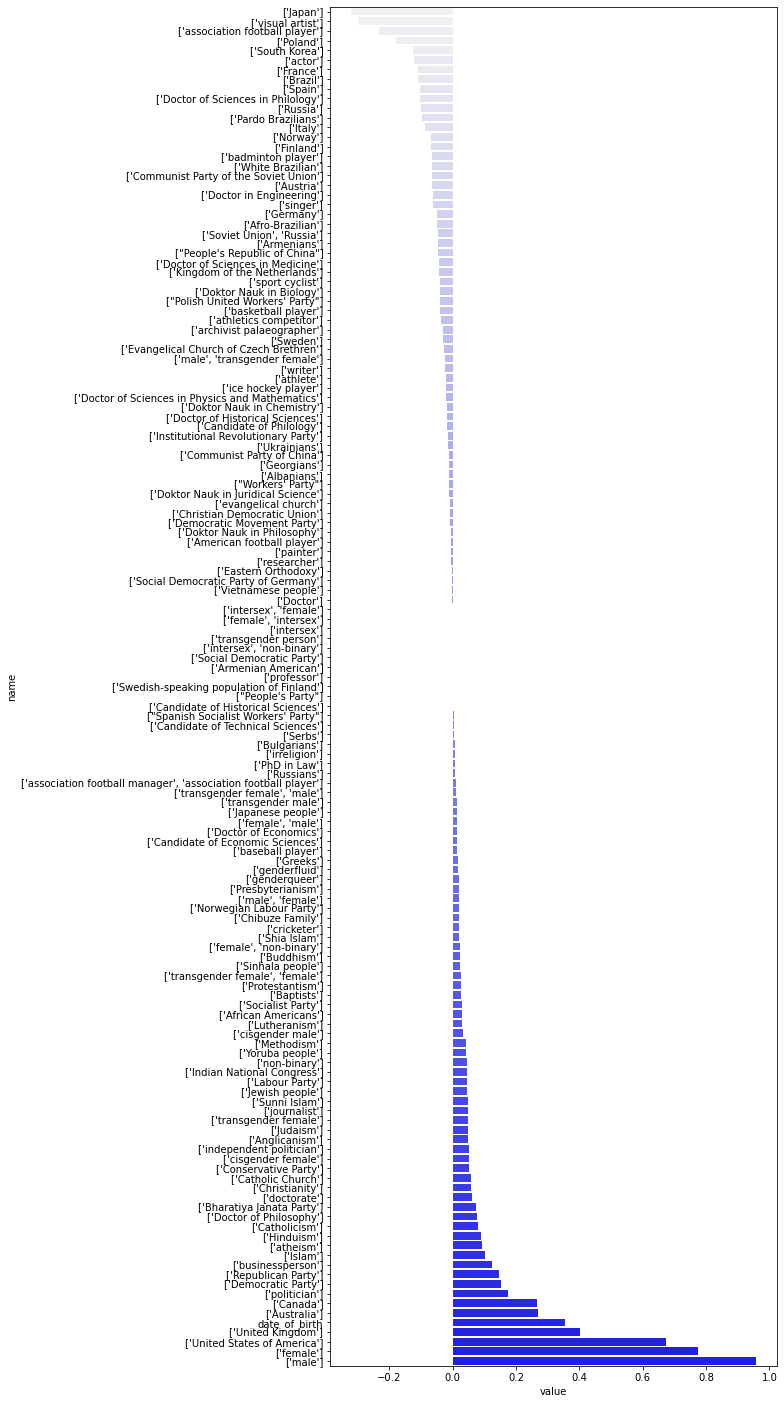

In [42]:
features_imp (X_smote.columns, logistic.coef_[0])

In [86]:
sub_features_train=train_scaled.iloc[:,np.where(logistic.coef_[0]>0.015)[0]]
sub_features_test =test_scaled.iloc[:,np.where(logistic.coef_[0]>0.015)[0]]

The accuracy of this model is 0.856
For the positive case, the precision is 0.067, the recall is 0.583 and the F1 score is 0.120
For the negative case, the precision is 0.992, the recall is 0.861 and the F1 score is 0.922


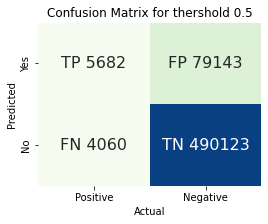

In [87]:
logistic_bis=LogisticRegression(solver ='lbfgs', penalty = 'l2', C=0.1, max_iter=1000)
logistic_bis.fit(sub_features_train, y_smote)

prediction_proba=logistic_bis.predict_proba(sub_features_test) 
    
#construct the confusion matrix
confusion_matrix_05_sub_model = compute_confusion_matrix(y_test, prediction_proba, 0.5)

plt.figure(figsize = (4,3))   
ax = plot_confusion_matrix(confusion_matrix_05_sub_model)

#setting axis
plt.xlabel('Actual')
plt.ylabel('Predicted')
ax.set(title = 'Confusion Matrix for thershold 0.5')
    
#get the accuracy of the model
accuracy (confusion_matrix_05_sub_model)

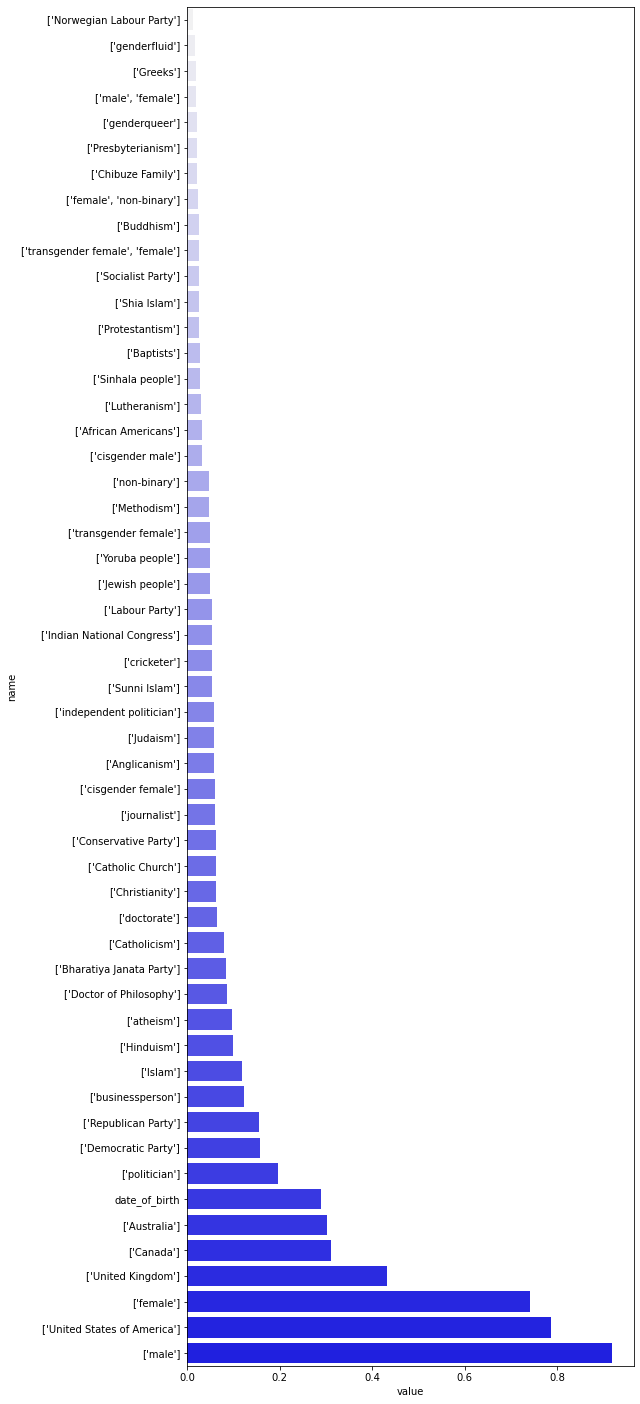

In [88]:
features_imp (sub_features_train.columns, logistic_bis.coef_[0])

#### 2.2 - classification per caracheristic 

In [120]:
occupation_train = X_smote.iloc[:, 1:21]
occupation_test = X_test.iloc[:, 1:21]
gender_train = X_smote.iloc[:, 121:141]
gender_test = X_test.iloc[:, 121:141]
nationality_train =X_smote.iloc[:, 61:81]
nationality_test  = X_test.iloc[:, 61:81]
academic_degree_train =X_smote.iloc[:, 101:121]
academic_degree_test  = X_test.iloc[:, 101:121]

In [157]:
dico={'occupation' : [occupation_train, occupation_test], 'gender' : [gender_train,gender_test],  
      'nationality ':[nationality_train, nationality_test], 'academic_degree' : [academic_degree_train, academic_degree_test] }

In [158]:
#declaration of a pipe flow
pipe = Pipeline([('logistic',LogisticRegression())])
    
    
# pipe flow is :
#  Scaling the data -> SDGClassifier


#different parameters for hypertunning

penalty = ['l2'] 
solver=['lbfgs']
max_iter=[10000]
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000] 


# make lists of different parameters to check
param_grid = dict( logistic__penalty=penalty, 
logistic__C=C,logistic__solver=solver,logistic__max_iter=max_iter) 




# initialize
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 5) 
    
#fit
for name, data in dico.items() :
    grid_result = grid.fit(data[0], y_smote)  
    print(f'Best Score for non standarized {name} is: ', grid_result.best_score_) 
    print(f'Best Params for non standarized {name} is : ', grid_result.best_params_) 

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score for non standarized occupation is:  0.6033754400633285
Best Params for non standarized occupation is :  {'logistic__C': 10, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score for non standarized gender is:  0.5416789250173946
Best Params for non standarized gender is :  {'logistic__C': 100, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score for non standarized nationality  is:  0.514074828140676
Best Params for non standarized nationality  is :  {'logistic__C': 1, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score for non standarized academic_degree is:  0.5057037503741508
Best Params for non standarized ac

In [159]:
#declaration of a pipe flow
pipe = Pipeline([('std_slc', StandardScaler()),
                ('logistic',LogisticRegression())])
    
    
# pipe flow is :
# Scaling the data -> Logistic regression


#different parameters for hypertunning

penalty = ['l2'] 
solver=['lbfgs', 'sag']
max_iter=[10000]
C = [0.001, 0.01, 0.1, 1, 10, 100] 


# make lists of different parameters to check
param_grid = dict( logistic__penalty=penalty, 
logistic__C=C,logistic__solver=solver,logistic__max_iter=max_iter) 




    
# initialize
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 5) 
#fit
for name, data in dico.items() :
    grid_result = grid.fit(data[0], y_smote)  
    print(f'Best Score for  standarized {name} is : ', grid_result.best_score_) 
    print(f'Best Params for  standarized {name} is: ', grid_result.best_params_) 

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score for  standarized occupation is :  0.6033755042316895
Best Params for  standarized occupation is:  {'logistic__C': 0.01, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score for  standarized gender is :  0.5416553505487942
Best Params for  standarized gender is:  {'logistic__C': 0.01, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score for  standarized nationality  is :  0.5140719101255963
Best Params for  standarized nationality  is:  {'logistic__C': 1, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'sag'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score for  standarized academic_degree is :  0.5057034064975499
Best Params for  standarized academic_degree is:

## *Let's see the result !*

The accuracy of this model is 0.911
For the positive case, the precision is 0.040, the recall is 0.189 and the F1 score is 0.067
For the negative case, the precision is 0.985, the recall is 0.923 and the F1 score is 0.953
The accuracy of this model is 0.983
For the positive case, the precision is 0.070, the recall is 0.001 and the F1 score is 0.003
For the negative case, the precision is 0.983, the recall is 1.000 and the F1 score is 0.991
The accuracy of this model is 0.978
For the positive case, the precision is 0.075, the recall is 0.025 and the F1 score is 0.038
For the negative case, the precision is 0.984, the recall is 0.995 and the F1 score is 0.989
The accuracy of this model is 0.982
For the positive case, the precision is 0.084, the recall is 0.005 and the F1 score is 0.010
For the negative case, the precision is 0.983, the recall is 0.999 and the F1 score is 0.991


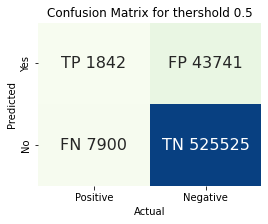

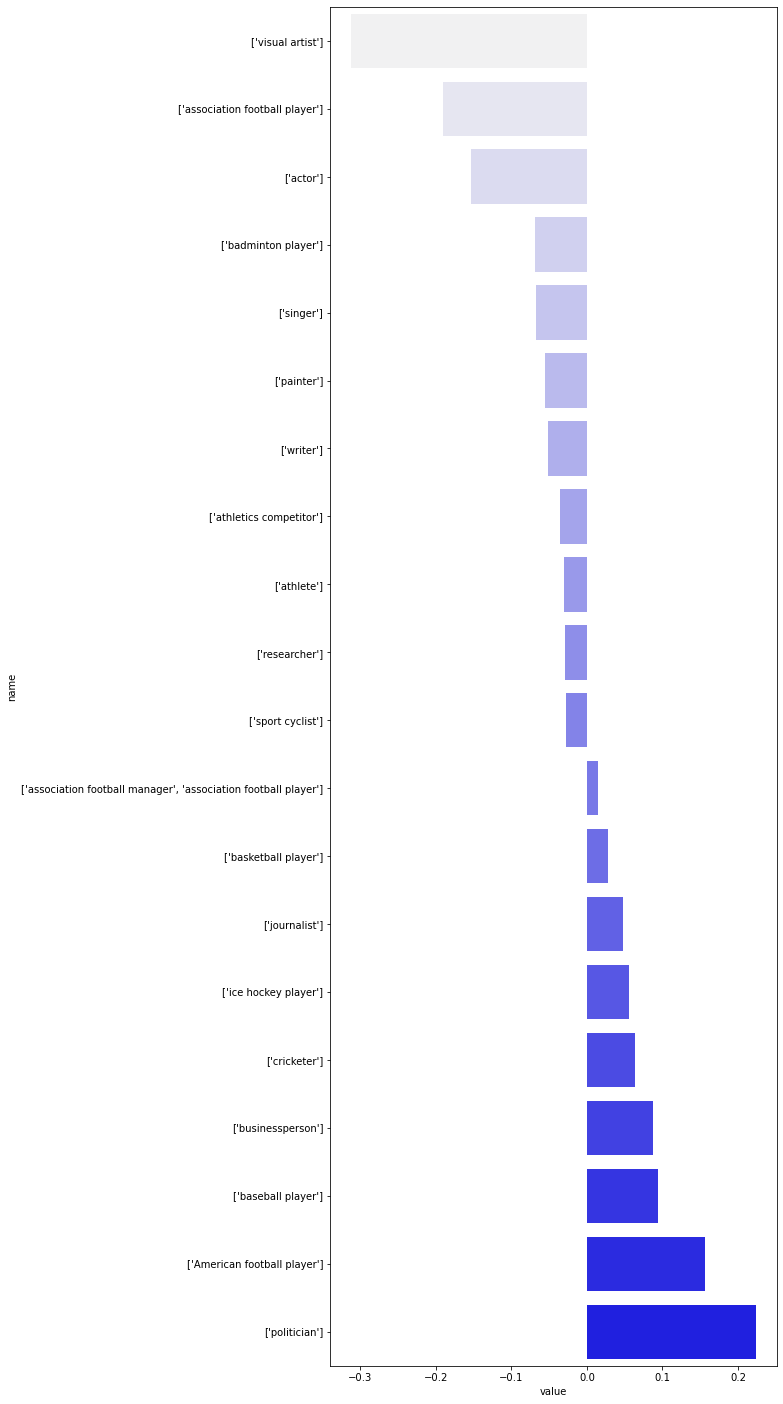

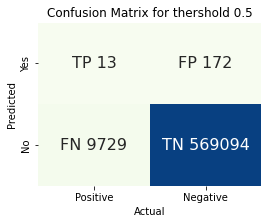

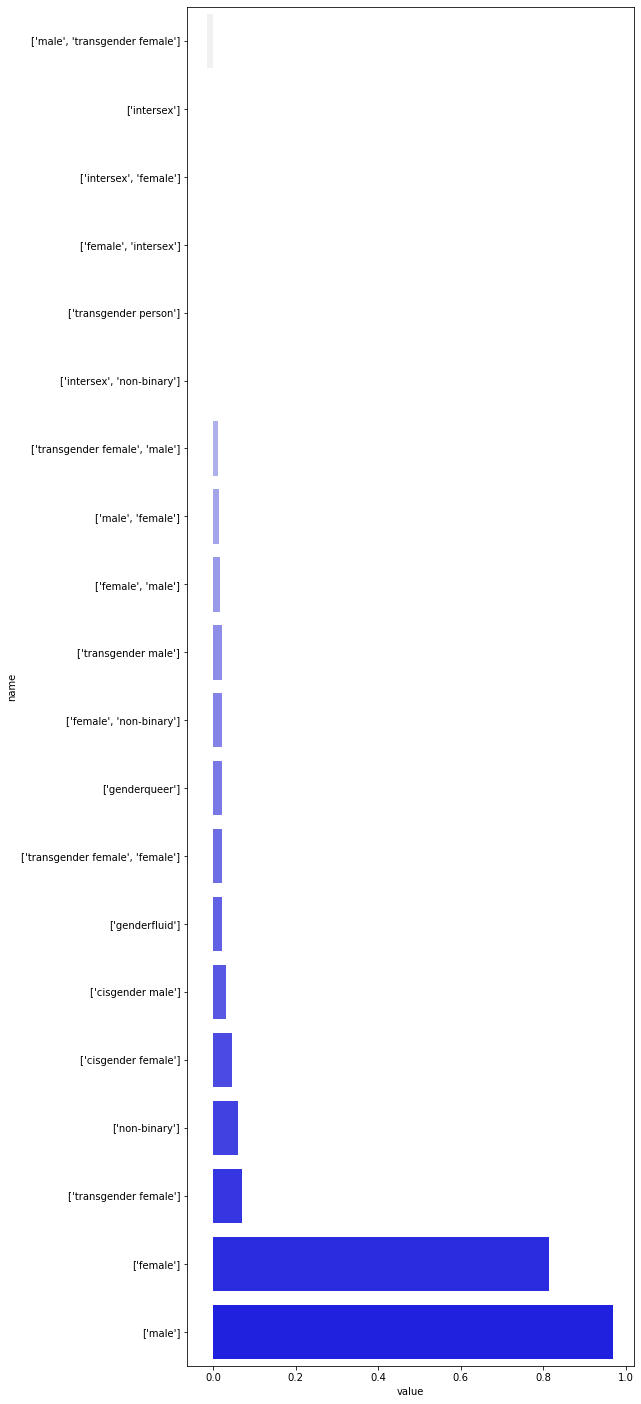

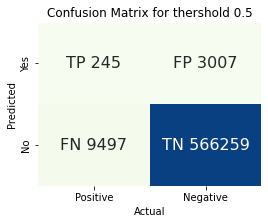

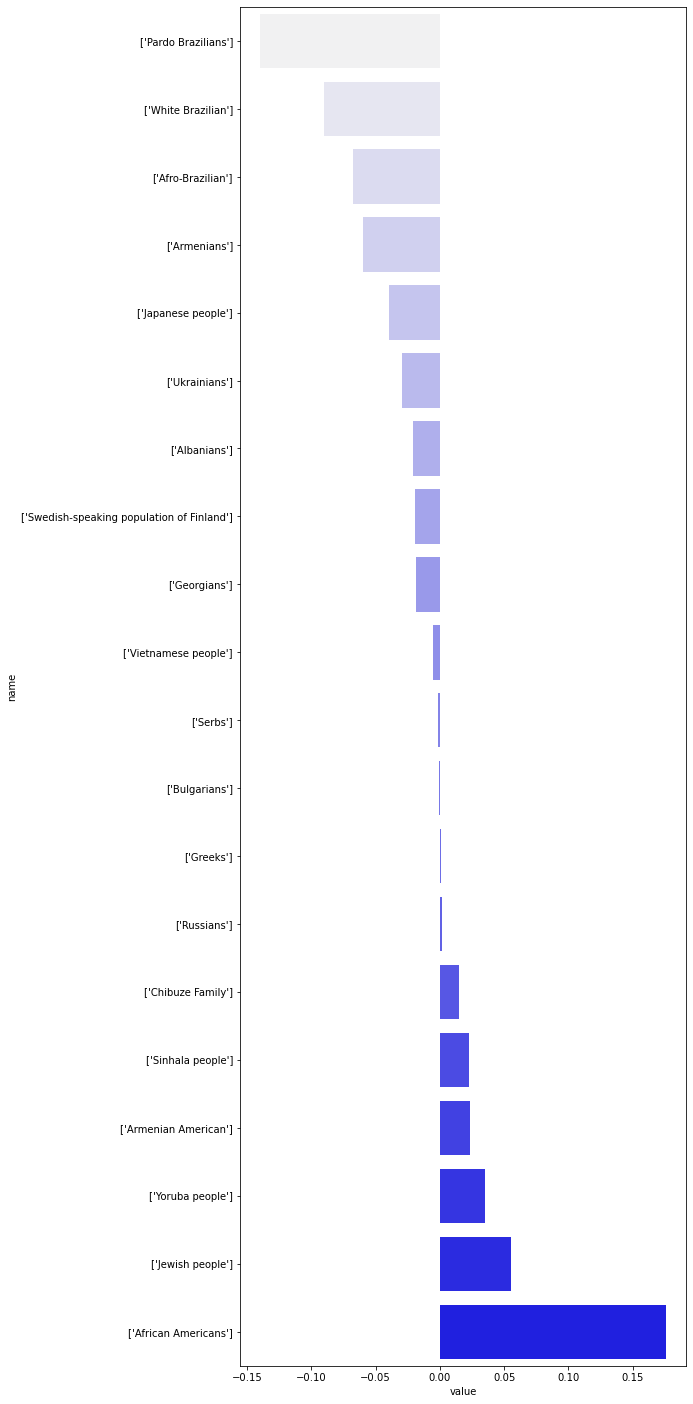

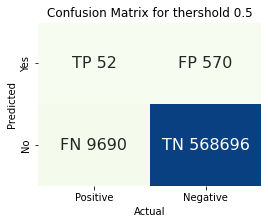

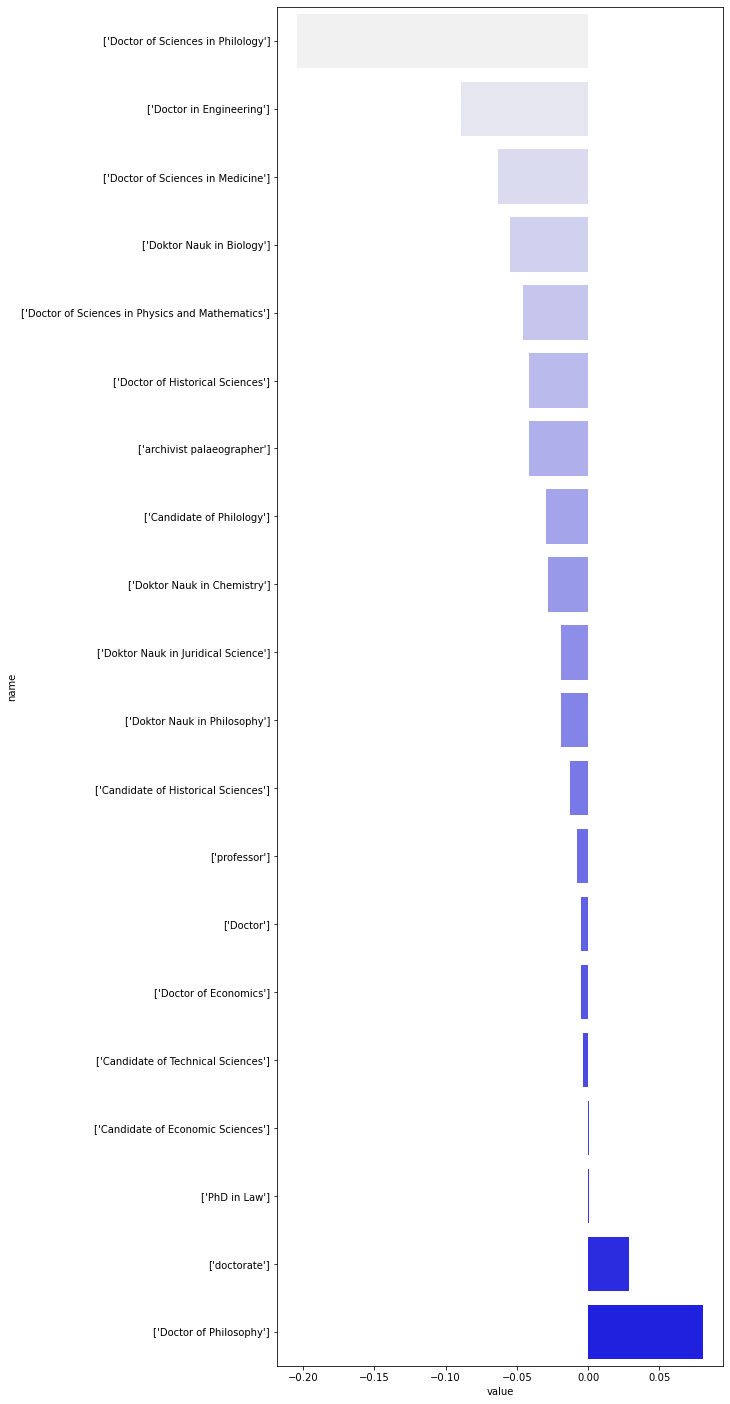

In [174]:
C=[0.01, 0.01, 1, 100]

i=0
for name, data in dico.items() :
    
    scaler=StandardScaler()
    scaler.fit(data[0])
    
  
    train_scaled_ = pd.DataFrame(scaler.transform(data[0]), columns=data[0].columns) 
    test_scaled_ = pd.DataFrame(scaler.transform(data[1]), columns=data[1].columns) 
    
   
    
    logistic_categories=LogisticRegression(solver ='lbfgs', penalty = 'l2', C=C[i], max_iter=10000)
    logistic_categories.fit(train_scaled_, y_smote)
    prediction_proba_categories=logistic_categories.predict_proba(test_scaled_) 
    
    
    #construct the confusion matrix
    confusion_matrix_05_sub_cat = compute_confusion_matrix(y_test, prediction_proba_categories, 0.5)
    plt.figure(figsize = (4,3))   
    ax = plot_confusion_matrix(confusion_matrix_05_sub_cat)
    #setting axis
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    ax.set(title = 'Confusion Matrix for thershold 0.5')
    #get the accuracy of the model
    accuracy (confusion_matrix_05_sub_cat)
    
    features_imp (train_scaled_.columns, logistic_categories.coef_[0])
    i+=1
    